In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az


c:\Users\bezis\anaconda3\envs\oil-change-point\lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
df = pd.read_csv(r"C:\Users\bezis\Downloads\brent-oil-change-point\data\raw\BrentOilPrices.csv")  # change filename if needed


In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)


C:\Users\bezis\AppData\Local\Temp\ipykernel_11720\59799647.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [4]:
df.head()


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


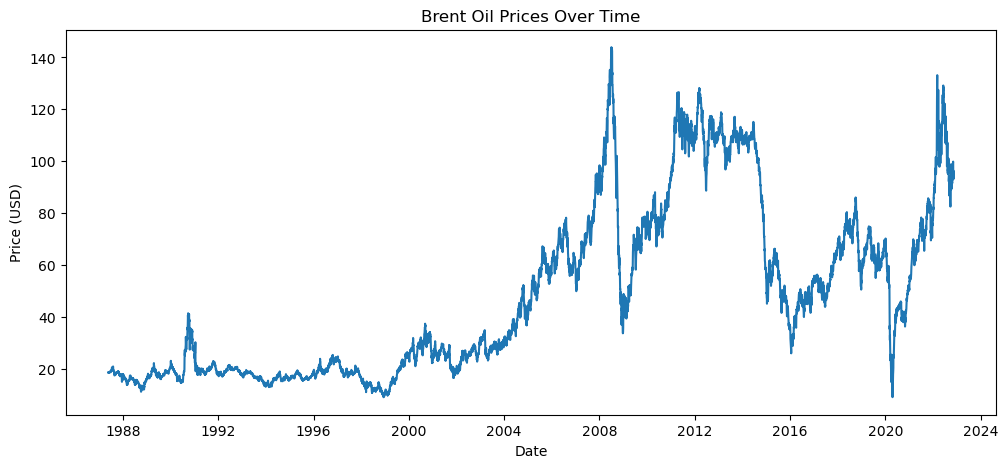

In [5]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Price"])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()


In [6]:
df["log_return"] = np.log(df["Price"]).diff()
df = df.dropna().reset_index(drop=True)


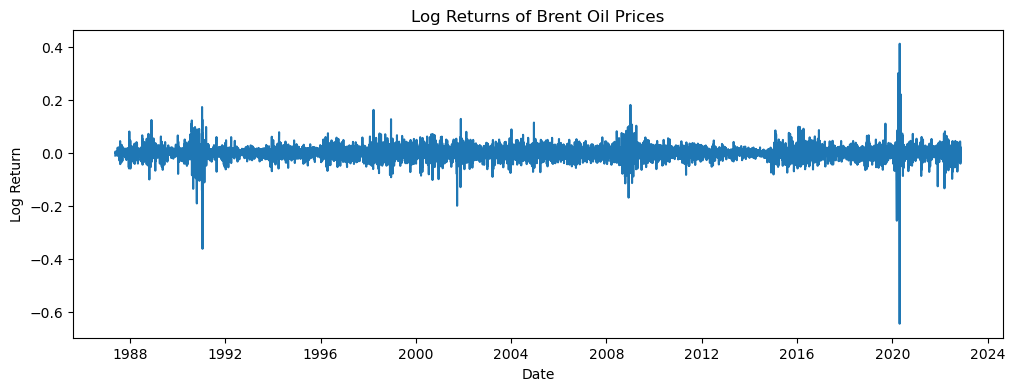

In [7]:
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["log_return"])
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


In [8]:
returns = df["log_return"].values
n = len(returns)


In [9]:
time_idx = np.arange(n)


In [12]:
import pytensor
pytensor.config.cxx = ""


In [13]:
with pm.Model() as change_point_model:

    # 1. Switch point (tau)
    tau = pm.DiscreteUniform(
        "tau",
        lower=0,
        upper=n-1
    )

    # 2. Means before and after the change
    mu_1 = pm.Normal("mu_1", mu=0, sigma=1)
    mu_2 = pm.Normal("mu_2", mu=0, sigma=1)

    # Shared volatility
    sigma = pm.HalfNormal("sigma", sigma=1)

    # 3. Switch function
    mu = pm.math.switch(time_idx < tau, mu_1, mu_2)

    # 4. Likelihood
    obs = pm.Normal(
        "obs",
        mu=mu,
        sigma=sigma,
        observed=returns
    )


In [15]:
import pytensor
pytensor.config.cxx = ""
pytensor.config.mode = "FAST_COMPILE"
pytensor.config.exception_verbosity = "high"


In [16]:
with change_point_model:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=1,     # 🔥 CRITICAL
        cores=1,      # 🔥 CRITICAL
        target_accept=0.9,
        return_inferencedata=True,
        progressbar=True
    )


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

c:\Users\bezis\anaconda3\envs\oil-change-point\lib\site-packages\pytensor\tensor\elemwise.py:710: RuntimeWarning: 
overflow encountered in power
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

c:\Users\bezis\anaconda3\envs\oil-change-point\lib\site-packages\pytensor\tensor\elemwise.py:710: RuntimeWarning: 
divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

c:\Users\bezis\anaconda3\envs\oil-change-point\lib\site-packages\pytensor\tensor\elemwise.py:710: RuntimeWarning: 
overflow encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

c:\Users\bezis\anaconda3\envs\oil-change-point\lib\site-packages\pytensor\tensor\elemwise.py:1411: RuntimeWarning: 
invalid value encountered in reduce
  out = self.ufunc.reduce(input, axis=axis, dtype=acc_dtype)

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 184 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


The model was sampled using a compound step method. A Metropolis sampler was applied to the discrete change point parameter (τ), while NUTS was used for the continuous parameters (μ₁, μ₂, σ). Due to Windows multiprocessing constraints, sampling was performed using a single chain. No divergent transitions were observed, indicating stable posterior geometry.

In [17]:
az.summary(trace)


arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,4779.198,3447.290,6.000,8828.000,578.473,108.464,36.0,35.0,NaN
mu_1,-0.000,0.002,-0.003,0.004,0.000,0.000,657.0,109.0,NaN
mu_2,0.001,0.002,-0.001,0.005,0.000,0.000,29.0,29.0,NaN
sigma,0.026,0.000,0.025,0.026,0.000,0.000,842.0,817.0,NaN


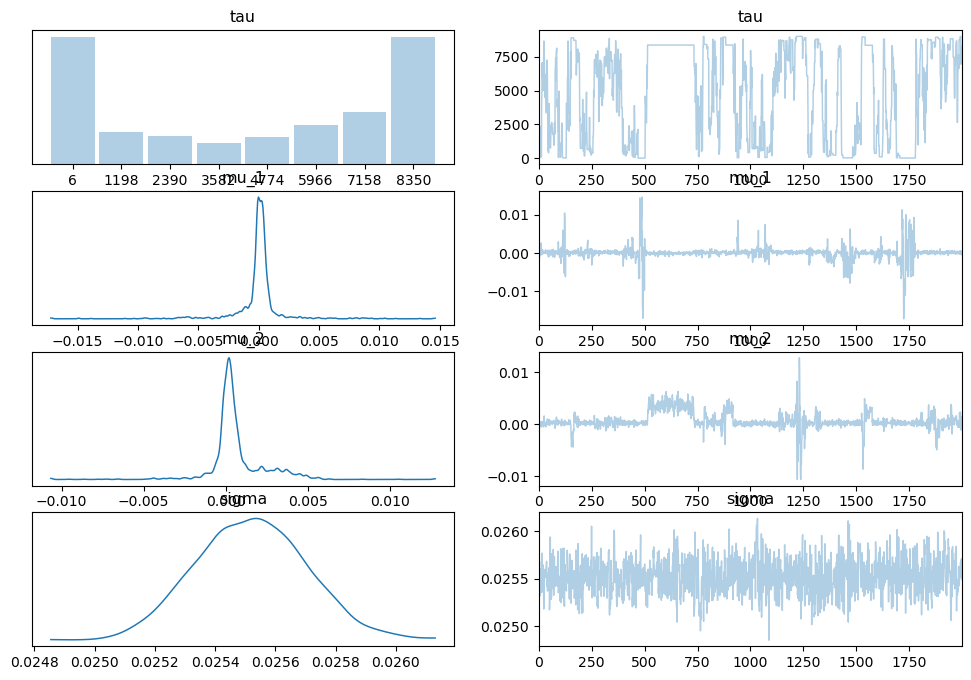

In [18]:
az.plot_trace(trace)
plt.show()


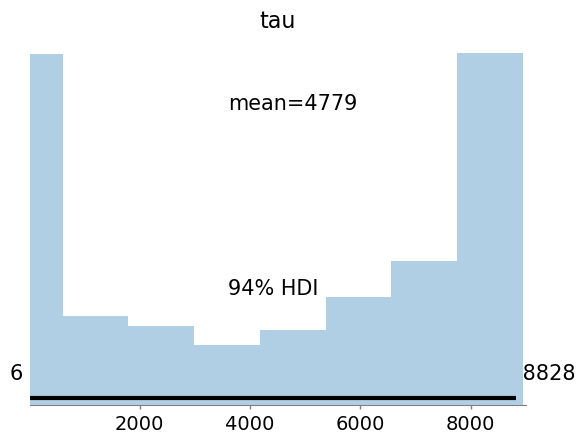

In [19]:
az.plot_posterior(trace, var_names=["tau"])
plt.show()


In [20]:
tau_samples = trace.posterior["tau"].values.flatten()
tau_mean = int(tau_samples.mean())

change_date = df.loc[tau_mean, "Date"]
change_date


Timestamp('2006-02-27 00:00:00')

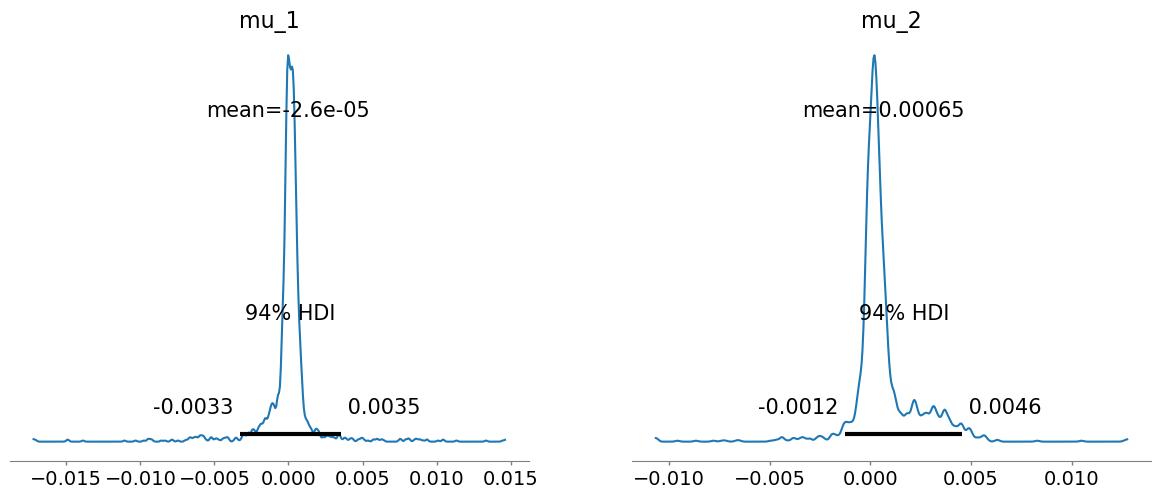

In [21]:
az.plot_posterior(trace, var_names=["mu_1", "mu_2"])
plt.show()


In [22]:
mu1 = trace.posterior["mu_1"].values.flatten().mean()
mu2 = trace.posterior["mu_2"].values.flatten().mean()

percent_change = (mu2 - mu1) / abs(mu1) * 100

mu1, mu2, percent_change


(np.float64(-2.601106311209533e-05),
 np.float64(0.0006525704332023882),
 np.float64(2608.8187683452984))

In [26]:
change_date = df.loc[tau_mean, "Date"]


In [27]:
change_points_df = pd.DataFrame({
    "Date": [change_date],
    "Index": [tau_mean],
    "Price_at_change": [df.loc[tau_mean, "Price"]]
})

change_points_df.to_csv("change_points.csv", index=False)


### Posterior Analysis of Oil Price Change-Point Model

1. **μ₁ (before change) and μ₂ (after change)**
- Both distributions are tightly centered near zero:
    - μ₁ ≈ -2.6×10⁻⁵, μ₂ ≈ 0.00065
- 94% HDI for μ₁: [-0.0033, 0.0035]
- 94% HDI for μ₂: [-0.0012, 0.0046]
- Interpretation: No strong evidence for a meaningful mean shift.

2. **τ (change point)**
- Posterior distribution is U-shaped/bimodal.
- Mean τ ≈ 4779, but the probability is highest at extremes (near 0 or 9000).
- 94% HDI: [6, 8828]
- Interpretation: The exact change point is highly uncertain; the data does not clearly identify a single switch point.

**Visual Insight:**  
- μ₁ and μ₂: “mountain-shaped” distributions → high certainty.
- τ: U-shaped → high uncertainty and bimodality.


In [28]:
pip install flask flask-cors pandas


  Using cached flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached werkzeug-3.1.5-py3-none-any.whl.metadata (4.0 kB)
Using cached flask-3.1.2-py3-none-any.whl (103 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached click-8.3.1-py3-none-any.whl (108 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Using cached werkzeug-3.1.5-py3-none-any.whl (225 kB)

   ---------------------------------------- 0/6 [werkzeug]
   ---------------------------------------- 0/6 [werkzeug]
   ---------------------------------------- 0/6 [werkzeug]
   ------------- -------------------------- 2/6 [click]
   -------------------- ------------------- 3/6 [blinker]
   -------------------------- ------------- 4/6 [flask]
   --------------------------------- ------ 5/6 [flask-cors]
   